<a href="https://colab.research.google.com/github/wallik2/All_Search_Algorithm_Game/blob/main/Maze_Runner_Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## General search algorithm


The algorithm helps expanding the state space, started from the initial state.

We need to define actions and transition function between states so that we can list all possible "next" state from the current one.

The expansion of nodes stops when one of the goal state is found.


Large objects will be assigned values by reference, not making a copy of the original.
We need the copy library to help copying such objects.

In [ ]:
from copy import deepcopy
from numpy import array

![](https://i.ibb.co/ZGw4VQY/IMG-8111.jpg)

In [ ]:
# 1 as obstacle & Locked room

# 9 as fast shoe

mapArray = array([[0,1,0,0,0,0,0,0,0,1],
                  [0,0,0,0,1,1,0,0,1,1],
                  [0,1,0,0,1,0,0,0,0,0],
                  [0,1,1,0,0,0,1,1,1,1],
                  [0,0,0,0,0,0,0,0,1,0],
                  [0,1,1,1,1,1,0,0,1,0],
                  [0,1,0,0,0,0,0,0,1,0],
                  [0,1,1,0,1,1,1,1,0,0],  #Locking room here (the most rightward 1)
                  [0,0,0,0,0,0,1,0,1,0],
                  [0,0,0,0,0,0,1,0,0,0],
                  ])

### Node

Node in this problem contains

* mapArray : The current map in form of array which each element has its own representative number

* userIndex : Where the player are currently at in the map array

* lastMove : The action that has been applied to the parent node to become the current node; used for displaying the steps of actions

* fastShoe : the item that can change the path cost of stepping 'left','right','up','down' to be from 1 to 0.5 per step  (does not apply to the path cost of 'static')

* parent: The parent node of this node; used for tracing back the steps of actions

Actions can be moving left, right, up, down,and stay static .

<fieldset>

### Heuristic Function (h(n))

We use Euclidean distance as Heuristic function by comparing the distance between the goal and its current userIndex

---

### Approximated cost function (g(n))
Simply the cumulative path cost from the start to its current

---

### Evaluation function (f(n))
Since we implemented the A-star algorithm, then f(n) = h(n) + g(n)

In [ ]:
def manhattan(a, b):
    return sum(abs(val1-val2) for val1, val2 in zip(a,b))
 
def euclid(a, b):
    val = (sum((val1-val2)**2 for val1, val2 in zip(a,b)))**0.5
    return round(val,2)

In [ ]:
class Node():
    def __init__(self, mapArray, userIndex, lastMove,fastShoe,unlockDoor, path, cost, parent):
        self.mapArray = mapArray

        self.userIndex = userIndex

        self.lastMove = lastMove

        self.fastShoe = fastShoe
        self.unlockDoor = unlockDoor

        # 0.5 if wear fastshoe
        self.path = path 

        # g(node)
        self.cost = cost

        self.parent = parent
    

    # Define as Heuristic Function : h(node)
    def evl_func(self):

      if not self.fastShoe:
        goal = [6,3]
      
      elif not self.unlockDoor and self.fastShoe :
        goal = [2,9]

      else:
        goal = [9,8]

      return self.cost + euclid(self.userIndex , goal)
      

    def __repr__(self):
      return f'Node({self.userIndex})'

    
actionList = ['left','right', 'up','down']
#actionList = ['left','right', 'up','down','static']

In [ ]:
initial = Node(mapArray = mapArray, 
               userIndex = [0,0],
               lastMove = None,
               fastShoe=False,
               unlockDoor=False,
               path = 1,
               cost = 0,
               parent = None)

### Transition

Transition maps the current node and action to the child node.

* If there is no obstacle at the left and the room is not the leftmost, then we can move left (The userindex column is decreased by 1)
* If there is no obstacle at the rightand the room is not the rightmost, then we can move right (The userindex column is increased by 1)
* If there is no obstacle at the upper, and the room is not the uttermost, then we can move up (The userindex row is decreased by 1)
* If there is no obstacle at the down, and the room is not the downmost, then we can move down (The userindex row is increased by 1)


If (node, action) do not fit any cases, userIndexbecomes None. If userIndex is None, nothing will be returned.

Otherwise, a child node is generated and returned.

Now we will suspect that does the node violate the rules or not like 'Have obstacle or have laser at that time at that userIndex or not, if yes then that child node got eliminated, also if at that userIndex have FastShoe then its path cost will be changed to 0.5, and if at that userIndex have Unlocking leer, then the mapArray at [7,7] of that child will be zero  

* Current action becomes the lastMove of the child
* Current node becomes the parent of the child


In [ ]:
def transition(node, action):
  
    mapArray = deepcopy(node.mapArray)
    userIndex = deepcopy(node.userIndex)

    if action == "left":
        if userIndex[1] > 0:
            userIndex[1] -= 1
        else:
            userIndex = None    

    elif action == "right":
        if userIndex[1] < 9 :
            userIndex[1] += 1
        else:
            userIndex = None    


    elif action == "up":
        if userIndex[0] > 0 :
            userIndex[0] -= 1
        else:
            userIndex = None    

    
    elif action == "down":
        if userIndex[0] < 9 :
            userIndex[0] += 1
        else:
            userIndex = None    
    
    """
    elif action == "static":
      path = 1
    """

    if userIndex != None :
      child = Node(mapArray = mapArray, 
                  userIndex = userIndex , 
                  lastMove = action,
                  fastShoe = node.fastShoe,
                  unlockDoor = node.unlockDoor,
                  path = node.path,
                  cost = node.cost+node.path ,
                  parent = node)
      
      #print(child.cost)
      if validator(child):                                                      #check if child stuck on an obstacle or got shot by a laser
        return None
                      
      if fastShoe(child):
        child.path = 0.5
        child.fastShoe = True
      
      if Unlock(child):
        child.mapArray[7,7] = 0  
        child.unlockDoor = True                                                      #update path or unlock its room
      
      return child


    else:
        return None

### Obstacle 

In [ ]:
def obstacle(node):

  row,col = node.userIndex[0], node.userIndex[1]

  if node.mapArray[row,col] == 1:
    return True

  return False

In [ ]:
def laser(node):
  
  userIndex = tuple( node.userIndex )
  if node.cost % 2 == 0:
    if (userIndex == (0,4)) | (userIndex == (9,7)):
      return True
  return False

In [ ]:
def fastShoe(node):
  #Fast shoe
  userIndex = tuple( node.userIndex )
  if userIndex == (6,2):
     print(f'Obtain Fast Shoes : {node.evl_func()}')
     return True

def Unlock(node):
  #Unlocking Lever
  userIndex = tuple( node.userIndex )
  if userIndex == (2,9):
     print(f"Unlock the door : {node.evl_func()}")
     return True

In [ ]:
def validator(node):
  if (obstacle(node) | laser(node)):
    return True

### Expand


Apply all possible transition to the given node

If the output is not empty, put it in the <b>listNextNode</b>

In [ ]:
def expand(node):
    listNextNode = []
    for action in actionList:
        #movable
        child = transition(node, action)
        if child != None:
          #select only success move
            listNextNode.append(child)
    return listNextNode

In [ ]:
# Test for initial

for i in expand(initial):
  print(i.lastMove)
  second = i

down


In [ ]:
# Test for the node after initial

for i in expand(second):
  print(i.lastMove)


right
up
down


### Goal 

Searching must stop when there is none of dirty room in the house

In [ ]:
def goalCheck(node):
    
    userIndex = deepcopy(node.userIndex)

    if userIndex == [9,8]:
      return True
    
    return False

### Solve


Frontier is the list of nodes waiting for expansion.

Frontier has only one member at the first start.

Then all children nodes from expansion are stored in here.

If a goal state is found, then stop and return solution path.
* Started from the goal state, iteratively trace for its parent node.
* The entire sequence is the solution path.

If frontier is empty, then stop and return nothing.

<details>
<summary>Tree Diagram</summary>

<img src='https://i.ibb.co/MNvnW2b/IMG-8072.jpg'>




</details>

In [ ]:
def d_sort(Node):
  return Node.evl_func()

class Frontier:
  def __init__(self,node=None):
    self.nodes = []
    
    if node:
      self.nodes += [node]
  
  def add(self,new_nodes):
    self.nodes += new_nodes
  
  def pop(self,position):
    return self.nodes.pop(position)

  def __len__(self):
    return len(self.nodes)
  
  def sort(self):
    self.nodes = sorted(self.nodes,key=d_sort)
  


Since it's possible that the optimal solution can repeat the userIndex, so we should filter the node by condition which I set into 4 conditions


1. Nothing
2. Only obtain fastshoe
3. Only unlock the door
4. Do both

So, we can let the nodes compete each other based on that condition

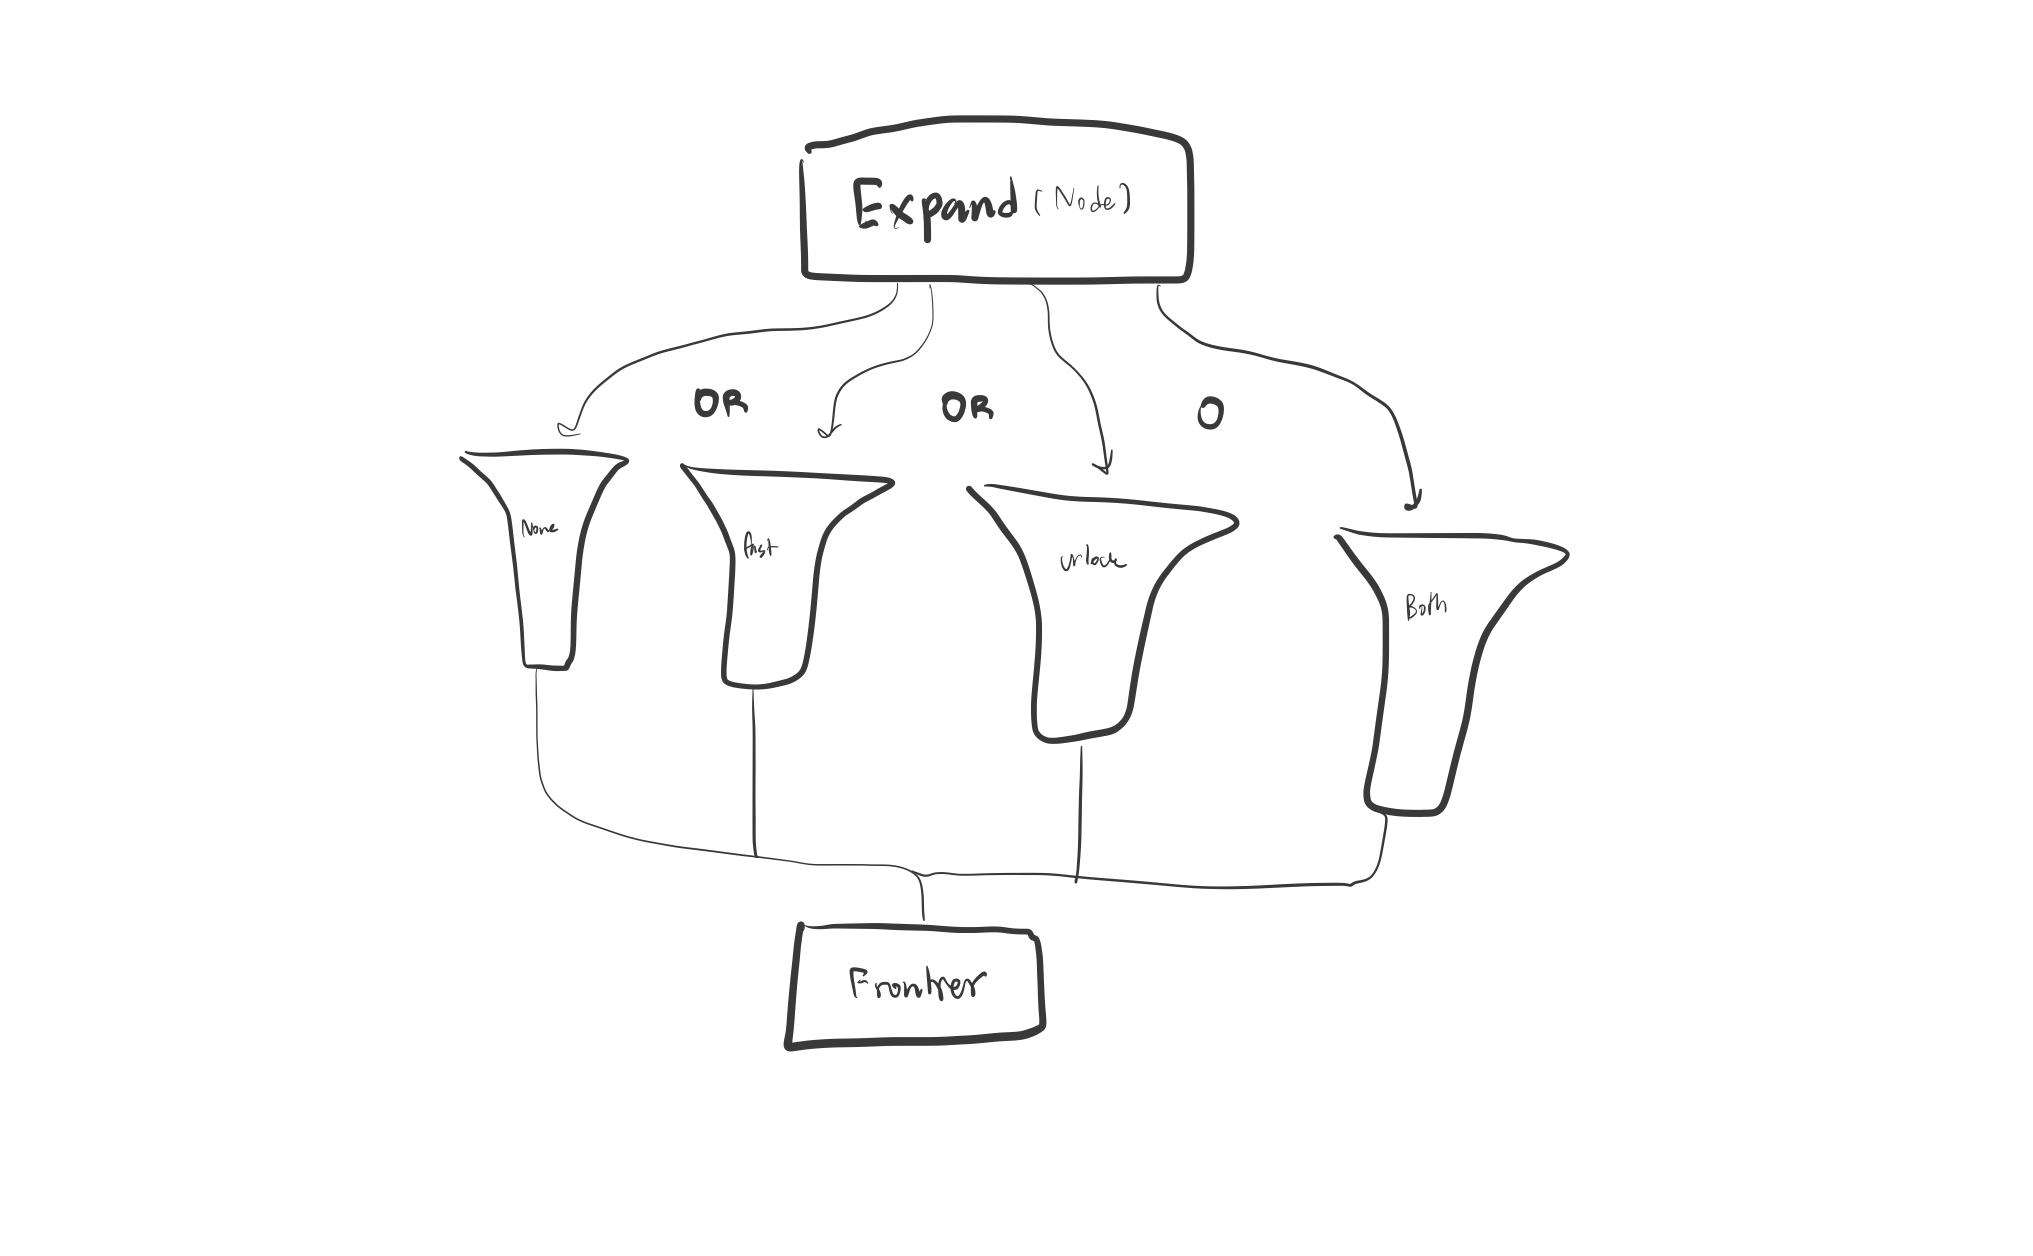

In [ ]:
def solve(initial):   
  
  #global frontier, so I can save the value of frontier when interrupt the running 
    global frontier
    global explored_none
    global explored_fast
    global explored_unlock
    global explored_both

    frontier = Frontier(initial)
    solution = []    

    # Conditional visited node 
    explored_none = []
    explored_fast = []
    explored_unlock = []
    explored_both = []

    while True:
        if len(frontier) == 0:
            break

        else:
           #inspect each parent node 
            node = frontier.pop(0)

            if node.unlockDoor and node.fastShoe:
              explored_both.append(node.userIndex)

            elif node.unlockDoor: 
             explored_unlock.append(node.userIndex)
            
            elif node.fastShoe:
              explored_fast.append(node.userIndex)

            else:
              explored_none.append(node.userIndex)



            # If all rooms of that node are cleaned, then extract all node that are their parent..
            if goalCheck(node):
                path = [node]

                # until meet the initial state which has no parent
                while node.parent != None : 
                    path.insert(0, node.parent)
                    node = node.parent                
                solution = path

                # Ready to return
                break

            # Not all rooms are clean
            else:

                # Append new node to frontier
                
                candidates = expand(node)

                # AVOID INFINITE LOOP
                for candidate in candidates:

                  # Do both Unlock & Fastshoe
                  if candidate.unlockDoor and candidate.fastShoe:
                    if candidate.userIndex in explored_both:
                      candidates.remove(candidate)
                  
                  # Just unlock the door
                  elif candidate.unlockDoor:
                    if candidate.userIndex in explored_unlock:
                      candidates.remove(candidate)

                  # Just obtain the fast shoe
                  elif candidate.fastShoe:
                    if candidate.userIndex in explored_fast:
                      candidates.remove(candidate)

                  # Neither unlock and obtain fastShoe
                  else:
                    if candidate.userIndex in explored_none:
                      candidates.remove(candidate)
                  
                frontier.add( candidates ) 
                frontier.sort()
                
    return solution

### Print solution

Show every variables inside each node in the solution path.

In [ ]:
def printSolution(solution):
    print('User action to find out the goal')
    for node in solution:
        print('Action: ', node.lastMove, ' User is at:', node.userIndex)
    
    print(f'\n Total Evaluation cost (f(n)): {solution[-1].cost}')

Test the entire algorithm with the initial node

In [ ]:
initial = Node(mapArray = mapArray, 
               userIndex = [0,0],
               lastMove = None,
               fastShoe=False,
               unlockDoor=False,
               path = 1,
               cost = 0,
               parent = None)

In [ ]:
#16.11
sln = solve(initial)

Obtain Fast Shoes : 15.0
Unlock the door : 20.21
Unlock the door : 20.21
Unlock the door : 22.21
Unlock the door : 22.21
Obtain Fast Shoes : 23.060000000000002
Unlock the door : 20.5
Obtain Fast Shoes : 27.0
Obtain Fast Shoes : 27.0
Unlock the door : 28.57


In [ ]:
printSolution(sln)

User action to find out the goal
Action:  None  User is at: [0, 0]
Action:  down  User is at: [1, 0]
Action:  down  User is at: [2, 0]
Action:  down  User is at: [3, 0]
Action:  down  User is at: [4, 0]
Action:  down  User is at: [5, 0]
Action:  down  User is at: [6, 0]
Action:  down  User is at: [7, 0]
Action:  down  User is at: [8, 0]
Action:  right  User is at: [8, 1]
Action:  right  User is at: [8, 2]
Action:  right  User is at: [8, 3]
Action:  up  User is at: [7, 3]
Action:  up  User is at: [6, 3]
Action:  left  User is at: [6, 2]
Action:  right  User is at: [6, 3]
Action:  right  User is at: [6, 4]
Action:  right  User is at: [6, 5]
Action:  right  User is at: [6, 6]
Action:  up  User is at: [5, 6]
Action:  up  User is at: [4, 6]
Action:  left  User is at: [4, 5]
Action:  up  User is at: [3, 5]
Action:  up  User is at: [2, 5]
Action:  right  User is at: [2, 6]
Action:  right  User is at: [2, 7]
Action:  right  User is at: [2, 8]
Action:  right  User is at: [2, 9]
Action:  left  U

Visually, This is the solution that A* suggests

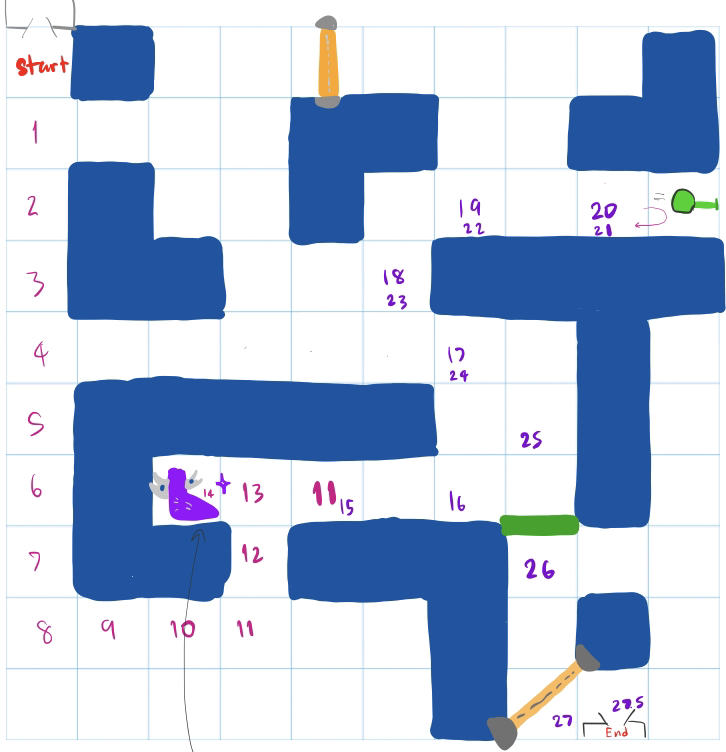

In [ ]:
"""
print( explored_none )
print( explored_fast )
print( explored_unlock )
print( explored_both )
"""
# Will change from set to list instead to save the memory from the duplicated userIndex

In [ ]:
#Just to inspect the path solution of each node in frontier
"""
def trysol(node):  
  node = frontier.pop(0)

  # If all rooms of that node are cleaned, then extract all node that are their parent..

  path = [node]

  # until meet the initial state which has no parent
  while node.parent != None : 
      path.insert(0, node.parent)
      node = node.parent                
  solution = path


  return solution
"""

# All the hardest parts are setting the right heuristic function and avoiding infinite loop

- Set Heuristic function h(n) = (9,8) alone does not give the optimal solution (it gave f(n) = 29)

- So,it's a bit cheating to have 3 conditional heuristic functions (which focus on getting fasting shoe before unlocking the door, and unlocking the door before reach the goal 


# What could we improve the search algorithm to ob tain optimal solution without need to know which heuristic function should it be first

1st Heuristic function : (9,8) 

2nd Heuristic function : (2,9) >> (9,8) 

3rd Heuristic function : (6,3) >> (2,9) >> (9,8) 

4th Heuristic function : (2,9) >> (6,3 >> (9,8) 

Then pick which optimal solution of these 4 heuristic functions is the lowest.